In [1]:
import tensorflow as tf
from tensorflow.python.keras import losses
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import sys
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
%cd /content/gdrive/My Drive/Colab Notebooks
print('os.path = ', os.path)
!#ls

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks
os.path =  <module 'posixpath' from '/usr/lib/python3.7/posixpath.py'>


In [2]:
def parse_image(img_path: str) -> dict:
    """
    img_path : str : Image (not the mask) location.
    dict: Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    # Decode a JPEG-encoded image to a uint8 tensor.
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # For one Image path:
    # .../dataset/images/training/im_00000001.jpg
    # Its corresponding annotation path is:
    # .../dataset/annotations/training/im_00000001.png
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations_binary")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class, which doesn't exist
    #mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}

In [3]:
import numpy as np
train_imgs = tf.data.Dataset.list_files("/content/gdrive/My Drive/Colab Notebooks/UWL/Unet/dataset/images/training/*.jpg")
test_imgs = tf.data.Dataset.list_files("/content/gdrive/My Drive/Colab Notebooks/UWL/Unet/dataset/images/testing/*.jpg")

In [4]:
train_set = train_imgs.map(parse_image)
test_set = test_imgs.map(parse_image)

dataset = {"train": train_set , "test": test_set}

In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask -= 1
  return input_image, input_mask

In [6]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [7]:
def load_image_train(datapoint):
  SIZE = 512
  input_image = tf.image.resize(datapoint['image'], (SIZE, SIZE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (SIZE, SIZE))
  input_image, input_mask = augment(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
def load_image_test(datapoint):
  SIZE = 512
  input_image = tf.image.resize(datapoint['image'], (SIZE, SIZE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (SIZE, SIZE))
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [9]:
train_dataset = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(load_image_test)

In [10]:
BUFFER_SIZE = 100
BATCH_SIZE = 8

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

validation_batches = test_dataset.take(96).batch(BATCH_SIZE)
test_batches = test_dataset.skip(100).take(54).batch(BATCH_SIZE)
train_batches = train_batches.prefetch(buffer_size=tf.data.AUTOTUNE)

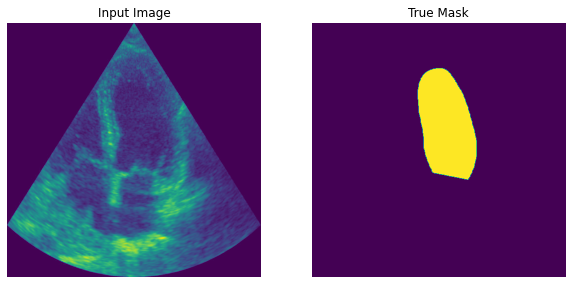

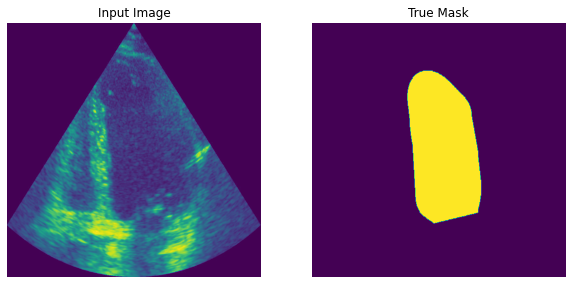

In [11]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
    #plt.colorbar()
  plt.show()
for image, mask in train_dataset.take(2):
   sample_image, sample_mask = image, mask
   display([sample_image, sample_mask])

In [12]:
def conv_block(input_tensor, num_filters):
  # Conv2D then batch normalization and ReLU activation
  encoder = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = tf.keras.layers.BatchNormalization()(encoder)
  encoder = tf.keras.layers.Activation('relu')(encoder)
  # Conv2D then batch normalization and ReLU activation
  encoder = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = tf.keras.layers.BatchNormalization()(encoder)
  encoder = tf.keras.layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  # upsample
  decoder = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  # concatenate
  decoder = tf.keras.layers.concatenate([concat_tensor, decoder], axis=-1)
  # batch normalization
  decoder = tf.keras.layers.BatchNormalization()(decoder)
  # ReLU activation
  decoder = tf.keras.layers.Activation('relu')(decoder)
  # Conv2D twice with batch normalization and ReLU activation
  decoder = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = tf.keras.layers.BatchNormalization()(decoder)
  decoder = tf.keras.layers.Activation('relu')(decoder)
  decoder = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = tf.keras.layers.BatchNormalization()(decoder)
  decoder = tf.keras.layers.Activation('relu')(decoder)
  return decoder

In [13]:
input_shape_image = [512, 512, 1]
OUTPUT_CHANNELS = 1 # no of classes

# inputs
inputs = tf.keras.layers.Input(shape=input_shape_image)

# encoder: contracting path - downsample
encoder0_pool, encoder0 = encoder_block(inputs, 32)
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)

# bottleneck
center = conv_block(encoder4_pool, 1024)

# decoder: expanding path - upsample
decoder4 = decoder_block(center, encoder4, 512)
decoder3 = decoder_block(decoder4, encoder3, 256)
decoder2 = decoder_block(decoder3, encoder2, 128)
decoder1 = decoder_block(decoder2, encoder1, 64)
decoder0 = decoder_block(decoder1, encoder0, 32)

# outputs
outputs = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, (1, 1), activation='sigmoid')(decoder0)

In [14]:
# unet model with Keras Functional API
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [15]:
def dice_coeff(y_true, y_pred, loss_type='sorensen', smooth=1.):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.
    Parameters
    -----------
    y_true : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    y_pred : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background),
            dice = ```smooth/(small_value + smooth)``,
            then if smooth is very small, dice close to 0 (even the image values lower than the threshold),
            so in this case, higher smooth can have a higher dice.
    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__
    """
    
    # https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
    #numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    #denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    #score = (numerator + 1) / (denominator + 1)
   
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    #y_true_f = tf.layers.flatten(y_true)
    #y_pred_f = tf.layers.flatten(y_pred)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    
    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    score = (2. * intersection + smooth) / (union + smooth)
    return score


In [16]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [17]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [18]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[bce_dice_loss])

In [19]:
def create_mask(pred_mask):
  #print(pred_mask.shape)
  #pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = tf.greater(pred_mask, 0.5)
  pred_mask = tf.dtypes.cast(pred_mask, tf.float32)
  #pred_mask = pred_mask[..., tf.newaxis]
  pred_mask = pred_mask[0]
  #print(pred_mask.shape)
  return pred_mask

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

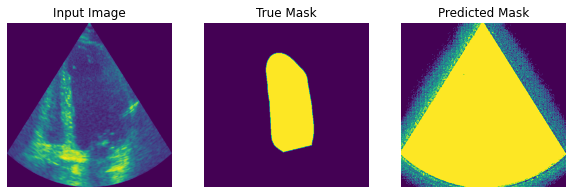

In [21]:
show_predictions()

In [22]:
import time
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
save_model_path = '/content/gdrive/My Drive/Colab Notebooks/Unet/' + timestr + '_weights-binary35.hdf5'
print(save_model_path)

/content/gdrive/My Drive/Colab Notebooks/Unet/2022-06-14_01-41-52_weights-binary35.hdf5


In [23]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_bce_dice_loss', mode='auto', save_best_only=True)

In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

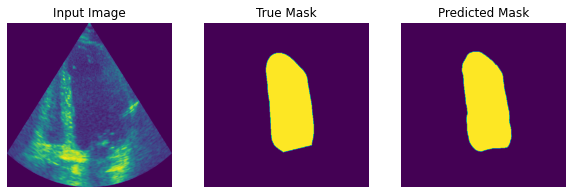


Sample Prediction after epoch 60

37/37 [==============================] - 32s 859ms/step - loss: 0.0421 - bce_dice_loss: 0.0421 - val_loss: 0.1237 - val_bce_dice_loss: 0.1237


In [25]:
EPOCHS = 60

TRAIN_LENGTH = 300
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
VALIDATION_STEPS = 96 //BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(train_batches, epochs=EPOCHS,
                           steps_per_epoch=STEPS_PER_EPOCH,
                           validation_steps=VALIDATION_STEPS,
                           validation_data=validation_batches,
                           callbacks=[DisplayCallback(),cp])

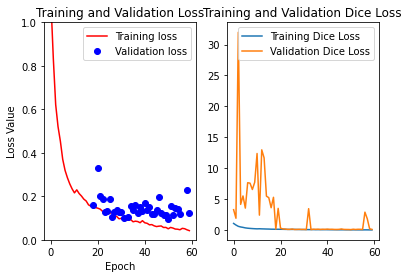

In [35]:
loss     = model_history.history['loss']
val_loss = model_history.history['val_loss']



plt.figure()
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend(loc='upper right')
epochs = model_history.epoch

dice     = model_history.history['bce_dice_loss']
val_dice = model_history.history['val_bce_dice_loss']

plt.subplot(1, 2, 2)
plt.plot(epochs, dice, label='Training Dice Loss')
plt.plot(epochs, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.show()

In [26]:
save_model_path1 = ('/content/gdrive/My Drive/Colab Notebooks/UWL/' + 'LV_Segmentation')
model.save(save_model_path1)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/UWL/LV_Segmentation/assets


In [36]:
# model.load_weights(save_model_path)
from tensorflow import keras
model2 = keras.models.load_model(save_model_path1, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})

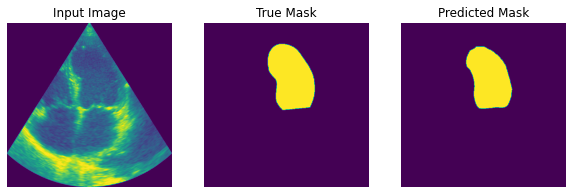

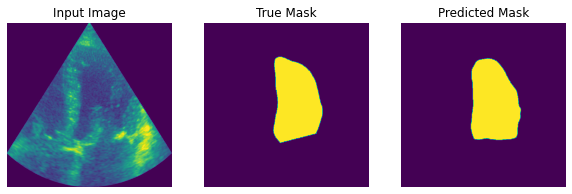

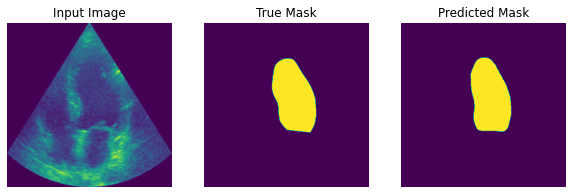

In [28]:
show_predictions(test_batches, 3)

In [29]:
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion, generate_binary_structure
from scipy.ndimage import _ni_support

def __surface_distances(result, reference, voxelspacing=None, connectivity=1):
    """
    The distances between the surface voxel of binary objects in result and their
    nearest partner surface voxel of a binary object in reference.
    """
    result = np.array(result, dtype=np.bool)
    result = np.atleast_1d(result)
    reference = np.array(reference, dtype=np.bool)
    reference = np.atleast_1d(reference)
    
    #result = np.atleast_1d(result.astype(np.bool))
    #reference = np.atleast_1d(reference.astype(np.bool))
    
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = np.asarray(voxelspacing, dtype=np.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
            
    # binary structure
    footprint = generate_binary_structure(result.ndim, connectivity)
    
    # test for emptiness
    if 0 == np.count_nonzero(result): 
        raise RuntimeError('The first supplied array does not contain any binary object.')
    if 0 == np.count_nonzero(reference): 
        raise RuntimeError('The second supplied array does not contain any binary object.')    
            
    # extract only 1-pixel border line of objects
    result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)
    
    # compute average surface distance        
    # Note: scipys distance transform is calculated only inside the borders of the
    #       foreground objects, therefore the input has to be reversed
    dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
    sds = dt[result_border]
    
    return sds

In [30]:
def Hausdorff_Distance(reference, result, voxelspacing=None, connectivity=1):
    """
    Hausdorff Distance.
    
    Computes the (symmetric) Hausdorff Distance (HD) between the binary objects in two
    images. It is defined as the maximum surface distance between the objects.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        Note that the connectivity influences the result in the case of the Hausdorff distance.
        
    Returns
    -------
    hd : float
        The symmetric Hausdorff Distance between the object(s) in ```result``` and the
        object(s) in ```reference```. The distance unit is the same as for the spacing of 
        elements along each dimension, which is usually given in mm.
        
    See also
    --------
    :func:`assd`
    :func:`asd`
    
    Notes
    -----
    This is a real metric. The binary images can therefore be supplied in any order.
    """
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity).max()
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity).max()
    hd = max(hd1, hd2)
    return hd

In [31]:
def Dice_Coefficient(reference, result):
    """
    Computes the Dice coefficient (also known as Sorensen index) between the binary objects in two images.

    result : Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    """
    result = np.array(result, dtype=np.bool)
    result = np.atleast_1d(result)
    result = tf.reshape(result, [-1])

    reference = np.array(reference, dtype=np.bool)
    reference = np.atleast_1d(reference)
    reference = tf.reshape(reference, [-1])
    
    intersection = np.count_nonzero(result & reference)
    
    size_i1 = np.count_nonzero(result)
    size_i2 = np.count_nonzero(reference)
    
    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    
    return dc

In [34]:
for image, mask in test_batches.take(2):
  pred_mask = model.predict(image)
#  tf.print('dice coefficient = ', dice_coeff(mask[0], create_mask(pred_mask)))
#  print('dice coefficient = ', Dice_Coefficient(mask[0], create_mask(pred_mask)))
#  print('Hausdorff_Distance = ', Hausdorff_Distance(mask[0], create_mask(pred_mask)))
  DC = Dice_Coefficient(mask[0], create_mask(pred_mask))
  print(DC/(2-DC))

  print("Image shape: ", image.shape)
  print("mask: ", mask.shape)
  print("pred_mask: ", pred_mask.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


0.8975233361269254
Image shape:  (8, 512, 512, 1)
mask:  (8, 512, 512, 1)
pred_mask:  (8, 512, 512, 1)
0.9200264375413088
Image shape:  (8, 512, 512, 1)
mask:  (8, 512, 512, 1)
pred_mask:  (8, 512, 512, 1)
